In [12]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
import itertools
from itertools import repeat
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [13]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["font.size"] = 14

In [14]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [15]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon


In [16]:
def get_freqs(ind):
    net = nets[ind]
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[ind])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    indexes = hist.index[hist.model_number.isin(models)]
    ages = hist.star_age[indexes]/1e6
    # print(len(freqs), len(ages))
    return freqs, ages


def interp(x, y, x_new):
    f_linear = interp1d(x, y, bounds_error=False, fill_value=0)
    return f_linear(x_new)


def model_nlm(ts):
    """
    Creates strings that uniquely identify each mode by the mode IDs.
    
    Input: theoretical spectrum (a pandas df)
    Output: theoretical spectrum (a pandas df) with the string column added.
    """
    id_strings = []
    if "m" not in ts.columns:
        ts["m"] = np.zeros(len(ts))
    for i,row in ts.iterrows():
        id_strings.append(str(int(row["n_pg"]))+str(int(row["l"]))+str(int(row["m"])))
    ts["nlm"] = id_strings
    return ts

mode_labels = ["n1ell0m0","n2ell0m0","n3ell0m0","n4ell0m0","n5ell0m0","n6ell0m0","n7ell0m0","n8ell0m0","n9ell0m0","n10ell0m0",
         "n1ell1mm1","n2ell1mm1","n3ell1mm1","n4ell1mm1","n5ell1mm1","n6ell1mm1","n7ell1mm1","n8ell1mm1","n9ell1mm1","n10ell1mm1",
         "n1ell1m0","n2ell1m0","n3ell1m0","n4ell1m0","n5ell1m0","n6ell1m0","n7ell1m0","n8ell1m0","n9ell1m0","n10ell1m0",
         "n1ell1mp1","n2ell1mp1","n3ell1mp1","n4ell1mp1","n5ell1mp1","n6ell1mp1","n7ell1mp1","n8ell1mp1","n9ell1mp1","n10ell1mp1"]
mode_strings = ["100","200","300","400","500","600","700","800","900","1000",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1",
         "110","210","310","410","510","610","710","810","910","1010",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1"]

In [17]:
def get_freqs_df_interp(ind, interpolate=True):
    freqs, ages = get_freqs(ind)
    dff = pd.DataFrame()
    dff["Dnu"] = np.repeat(np.nan, len(freqs))
    dff["eps"] = np.repeat(np.nan, len(freqs))
    for s in mode_labels:
        dff[s] = np.repeat(np.nan, len(freqs))

    freqs_df = []
    for i, row in dff.iterrows():
        df = row
        ts = freqs[i]
        ts = model_nlm(ts)
        df["age"] = ages.iloc[i]
        df["Dnu"] = model_Dnu(ts)
        df["eps"] = model_epsilon(ts)
        for j,s in enumerate(mode_strings):
            try:
                df[mode_labels[j]] = np.round(ts.query(f"nlm=='{s}'")["Re(freq)"].values[0],5)
            except:
                df[mode_labels[j]] = np.nan
        freqs_df.append(df)

    freqs_df = pd.DataFrame(freqs_df)

    l = 1
    for n in range(1, 11):
        freqs_df[f"n{n}ell{l}dfreq"] = freqs_df[f"n{n}ell{l}m0"] - freqs_df[f"n{n}ell{l}mm1"]
        freqs_df.drop(columns=[f"n{n}ell{l}mp1", f"n{n}ell{l}mm1"], inplace=True)
    columns = ['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
       'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
       'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
       'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']
    freqs_df = freqs_df[columns]
    
    if interpolate:
        # ages = np.linspace(15, freqs_df.iloc[-1]["age"], 100)
        ages = np.arange(0, freqs_df.iloc[-1]["age"], 0.1)
        new_df = pd.DataFrame()
        new_df["age"] = ages
        for column in columns[1:]:
            new_df[column] = interp(freqs_df["age"], freqs_df[column], ages)
        return new_df
    else:
        return freqs_df

In [19]:
logs_dirs = sorted(glob.glob("../test/r22.11.1_m1.7_z0.015_v0_net*/LOGS"))
nets = [logs_dir.split('/')[-2].split('net')[-1] for logs_dir in logs_dirs]
run_times = []
for i, logs_dir in enumerate(logs_dirs):
    logfn = "".join(logs_dir.split("LOGS")) + "run.log"
    with open(logfn, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Total" in line:
                run_time = float(line.split(" ")[-2])
                run_times.append(run_time)
# logs_dirs
print(run_times)
print(nets)
net_labels = [net.replace("_", "\\_") for net in nets]
net_labels

[128.95581531524658, 174.75741481781006, 282.2259466648102, 253.6868007183075, 158.2733702659607]
['basic', 'hot_cno', 'pp_and_cno_extras', 'pp_and_hot_cno', 'pp_extras']


['basic',
 'hot\\_cno',
 'pp\\_and\\_cno\\_extras',
 'pp\\_and\\_hot\\_cno',
 'pp\\_extras']

In [20]:
runtime_ratios = []
for i in range(len(nets)):
    runtime_ratios.append(round(run_times[i]/run_times[2], 2))
runtime_ratios

[0.46, 0.62, 1.0, 0.9, 0.56]

In [21]:
freqs_df_all = []
for i, net in enumerate(nets):
    freqs_df = get_freqs_df_interp(i, interpolate=False)
    freqs_df_all.append(freqs_df)

In [68]:
ages = [df["age"].values for df in freqs_df_all]

delta_nus = [df["Dnu"].values for df in freqs_df_all]

key_ref = 2

age_ref = np.arange(0, ages[key_ref][-1], 0.1)

predicted_ages = []
predicted_Dnus = []
for age, delta_nu in zip(ages, delta_nus):
    interp_func = interp1d(age, delta_nu)
    predicted_Dnus.append(interp_func(age_ref))
    interp_func = interp1d(delta_nu, age)
    predicted_ages.append(interp_func(delta_nu[key_ref]))


relative_errors = []
for i in range(0, len(predicted_ages)):
    relative_error = (predicted_ages[key_ref] - predicted_ages[i]) / predicted_ages[key_ref]
    relative_errors.append(relative_error)

ValueError: A value (0.0) in x_new is below the interpolation range's minimum value (1.0068397590879523).

In [67]:
df.columns

Index(['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
       'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
       'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
       'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq'],
      dtype='object')

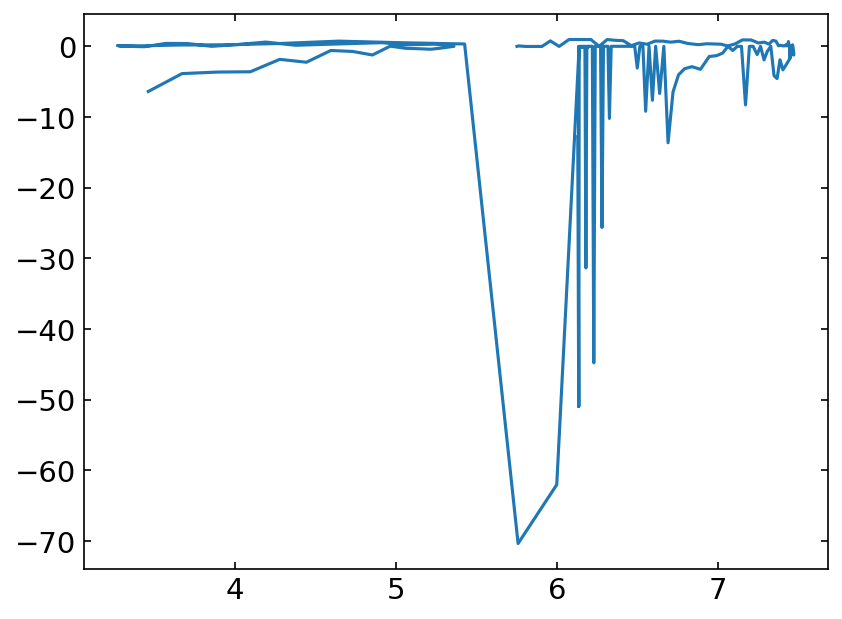

In [65]:
plt.plot(Dnu_values, relative_errors[0])
# plt.xlim(5, 20)

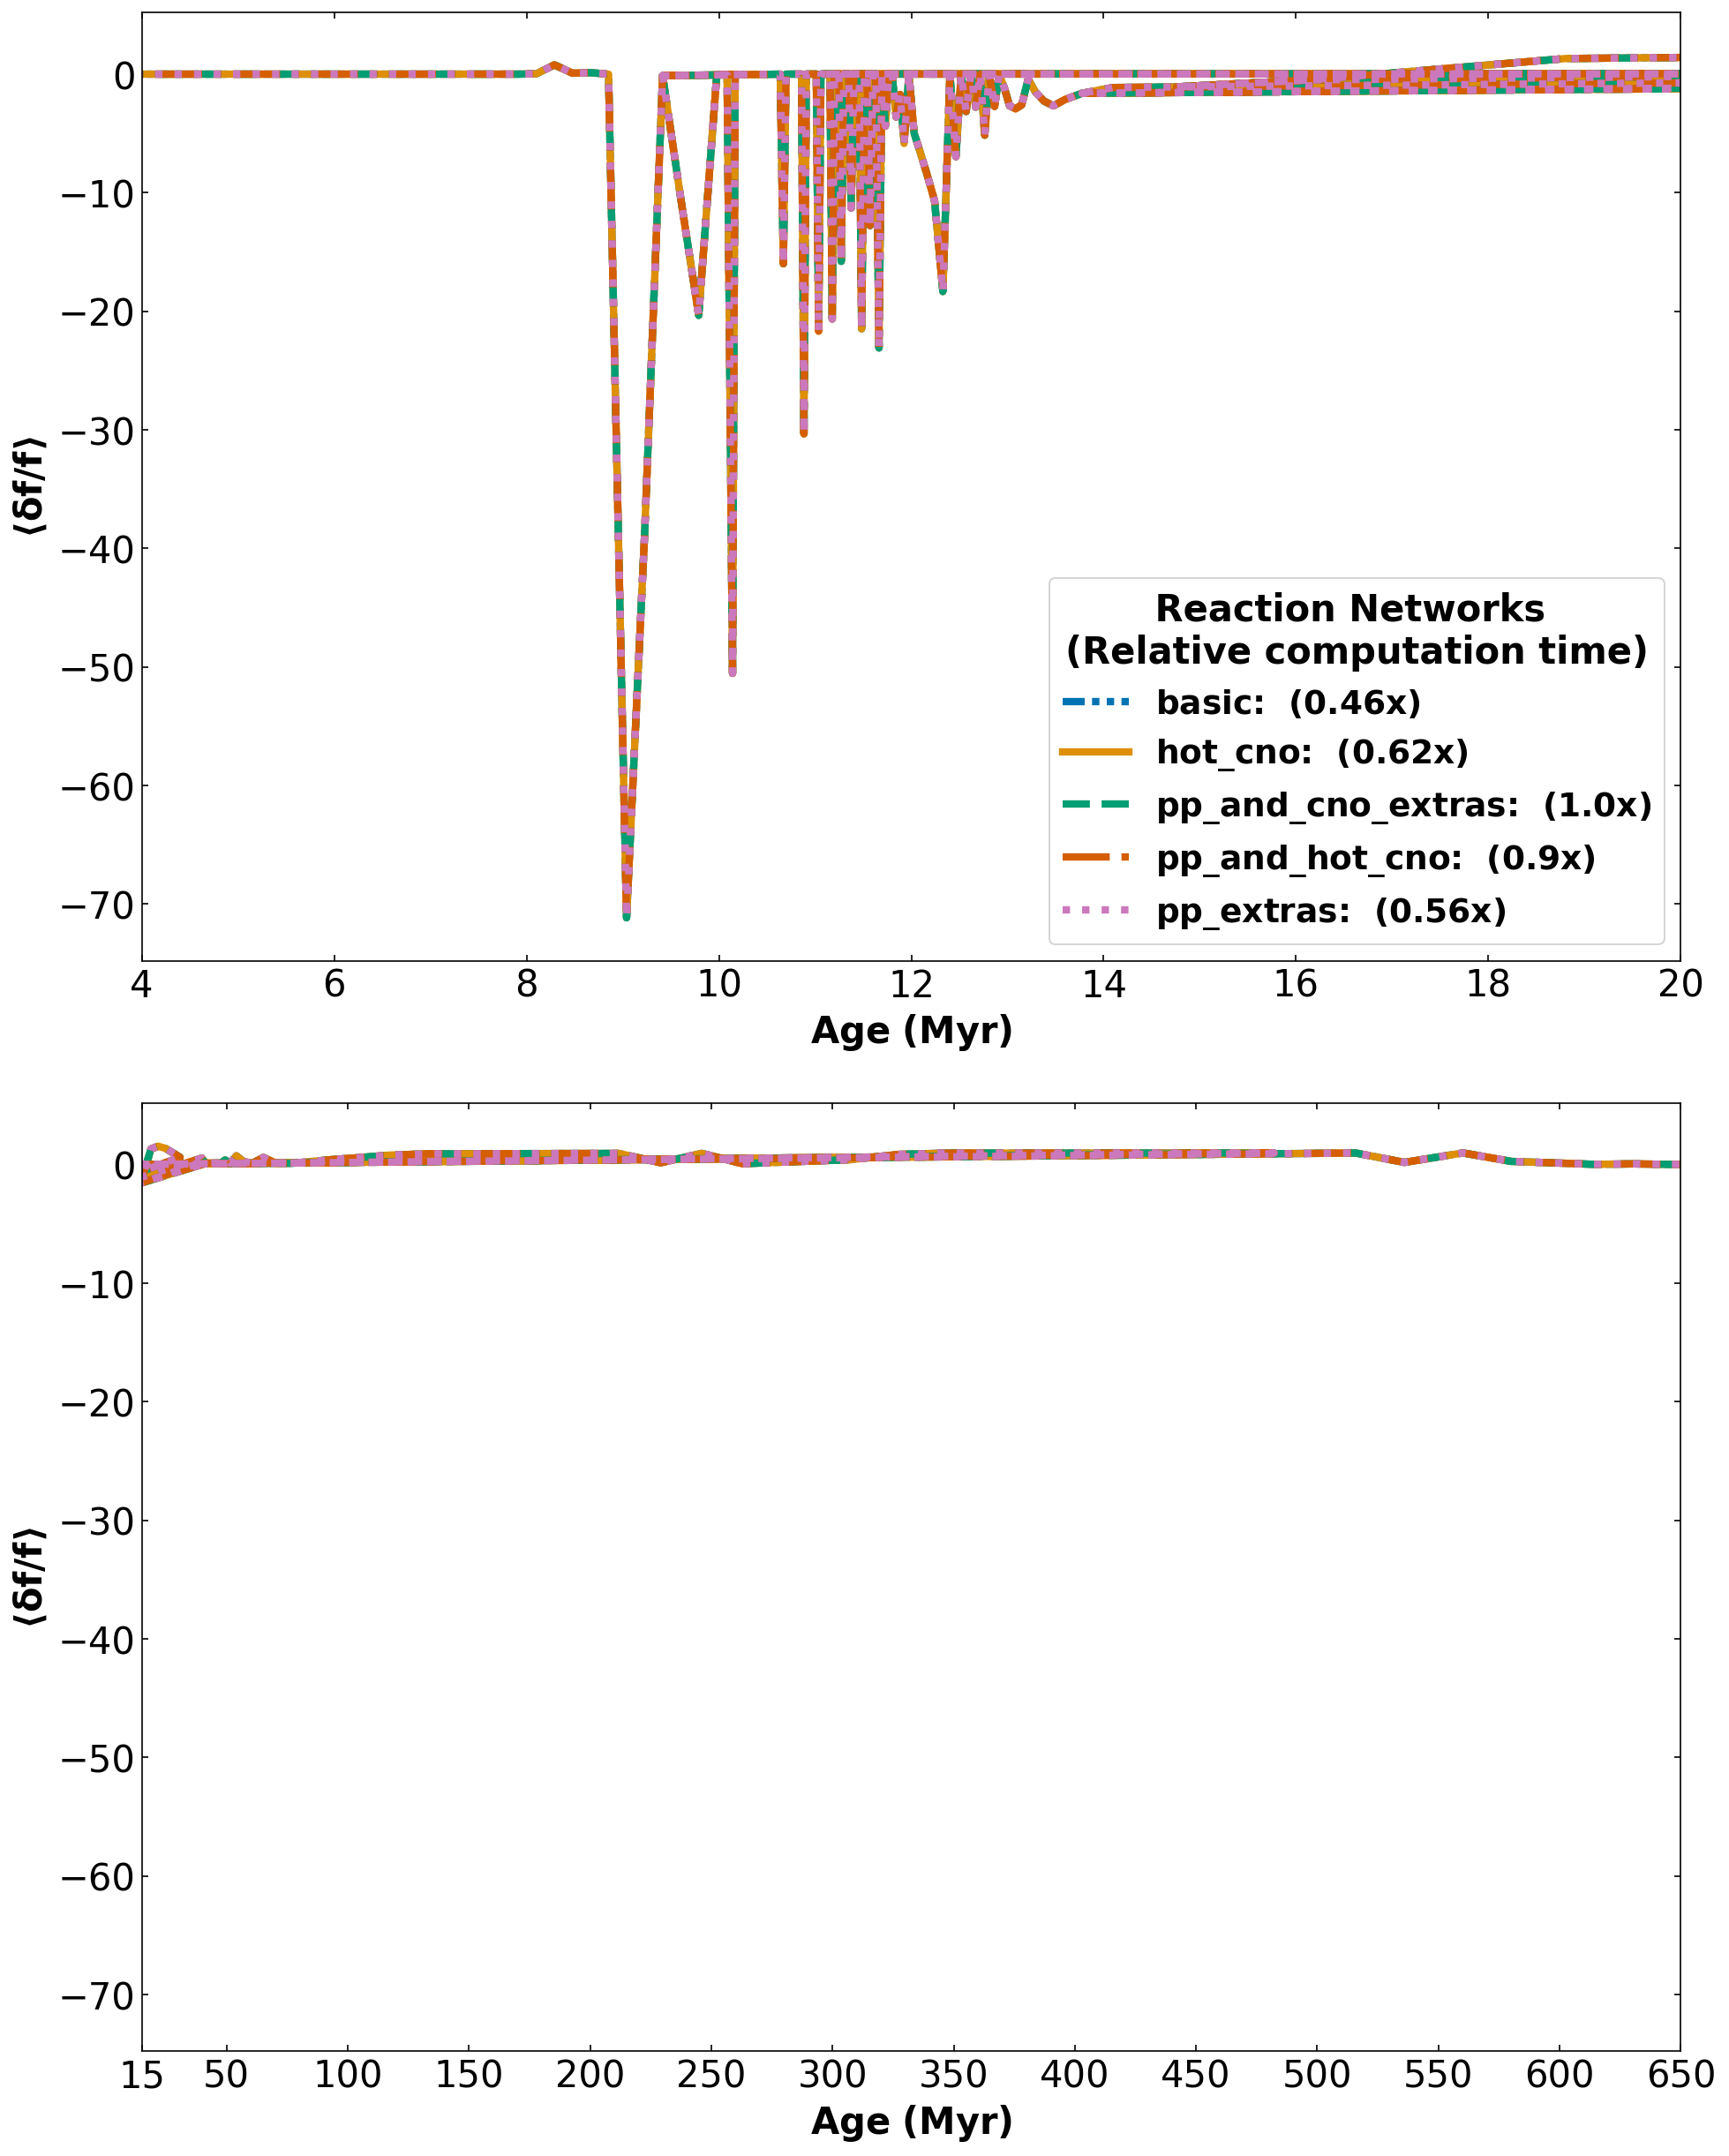

In [61]:
fig = plt.figure(figsize=(15, 20))
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("colorblind", 5)
# palette = ['#7a1679', '#0000ef', '#5fc9ca', '#377e2b', '#ea332c']

ax1 = plt.subplot(2, 1, 1)
for ind, net in enumerate(nets):
    plt.plot(predicted_ages[key_ref], relative_errors[i], color=palette[ind], linestyle=linestyle_tuple[ind], lw=4,
            label=fr"$\bf{{{net_labels[ind]}}}$"+f":  ({runtime_ratios[ind]}x)")
            # label=f"{net_labels[ind]}"+f":  ({runtime_ratios[ind]}x)")

title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
legend = plt.legend(title="       Reaction Networks\n(Relative computation time)", loc='lower right', 
                title_fontproperties=title_font, prop=font, fancybox=True)
plt.xlim([4, 20])
plt.xticks(np.arange(4, 22, 2))
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
rect = mpl.patches.Rectangle((15, -0.0035), 20, 0.0125, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
ax1.add_patch(rect)

ax2 = plt.subplot(2, 1, 2)
for ind, net in enumerate(nets):
    plt.plot(predicted_ages[key_ref], relative_errors[i], color=palette[ind], linestyle=linestyle_tuple[ind], lw=4,
             label=fr"$\bf{{{net_labels[ind]}}}$"+f":  ({runtime_ratios[ind]}x)")
            # label=f"{net_labels[ind]}"+f":  ({runtime_ratios[ind]}x)")
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
plt.xlim([15, 550])
plt.xticks([15, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650])
# plt.ylim([-0.0035, 0.009])
plt.subplots_adjust(wspace=0, hspace=0.15)

# rect = mpl.patches.Rectangle((15, -0.005), 20, 0.01, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
# ax2.add_patch(rect)

fig.align_ylabels([ax1, ax2])

plt.savefig(f'../figures/mean_diff_panels.pdf', dpi=300, bbox_inches='tight')

In [11]:
import numpy as np
from itertools import product

M = np.arange(1.5, 2.2, 0.2)
Z = np.arange(0.002, 0.023, 0.004)
V = np.arange(0, 14, 4)

len(list(product(M, Z, V)))

96

In [12]:
Z

array([0.002, 0.006, 0.01 , 0.014, 0.018, 0.022])